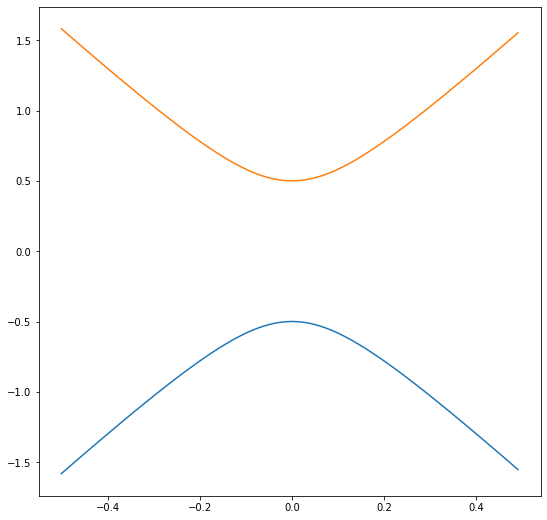

N =  60 Np =  3721
binding energies in monolayer:  [0.17473695 0.07568833 0.07067119 0.05546823 0.03759597]
binding energies in monolayer MoTe2 B exciton:  [0.20894544 0.09050594 0.08450658 0.06632732 0.04495618]
binding energies in twist MoTe2 1.0$^{\circ}$ [0.29601641 0.22684988 0.19637369 0.19085196 0.17929344]
binding energies in monolayer WSe2 B exciton1.0$^{\circ}$: [0.28221441 0.18826144 0.13885176 0.13370286 0.10931175 0.10177661
 0.08983027 0.08334094 0.08245777 0.07557282]
binding energies in twist MoTe2 1.0$^{\circ}$ [0.28710926 0.21926386 0.18766202 0.18387451 0.17258542]
binding energies in monolayer WSe2 B exciton1.0$^{\circ}$: [0.271871   0.1802089  0.13242219 0.11990929 0.10381724 0.09020492
 0.08496589 0.07338181 0.07256426 0.07123264]
binding energies in twist MoTe2 1.0$^{\circ}$ [0.28710926 0.21926386 0.18766202 0.18387451 0.17258542]
binding energies in monolayer WSe2 B exciton1.0$^{\circ}$: [0.271871   0.1802089  0.13242219 0.11990929 0.10381724 0.09020492
 0.08496

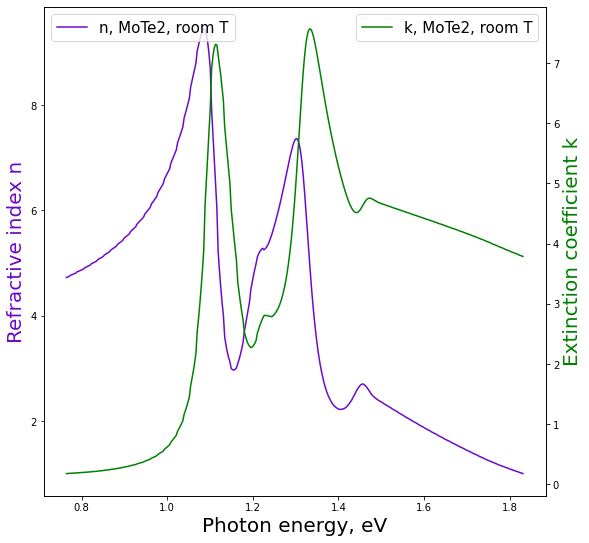

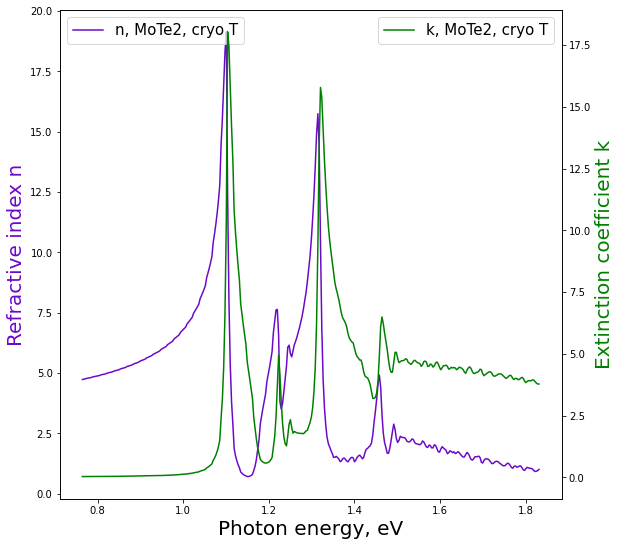

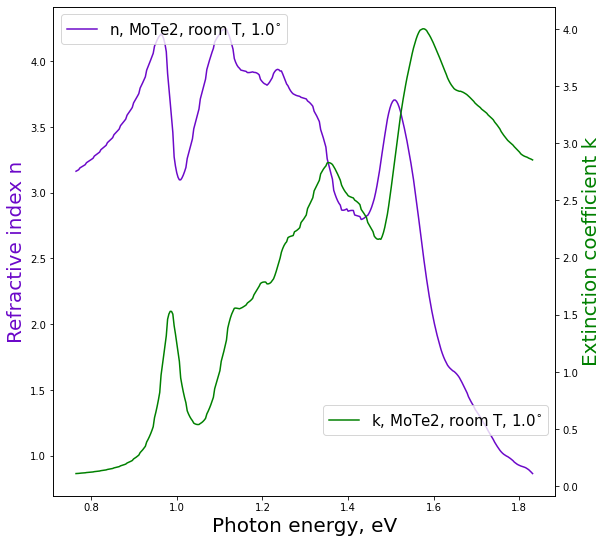

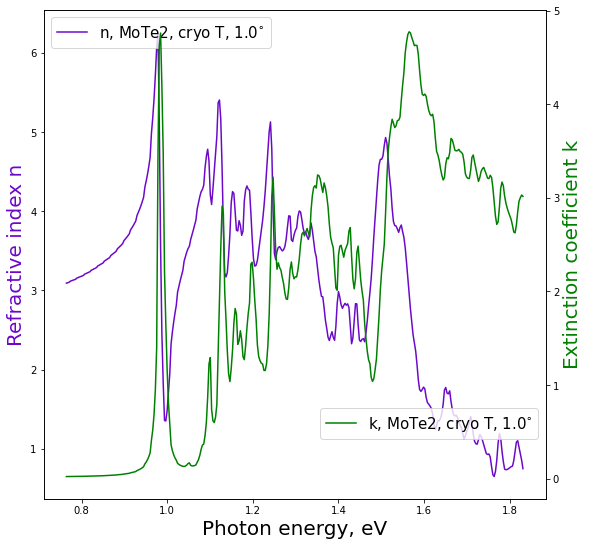

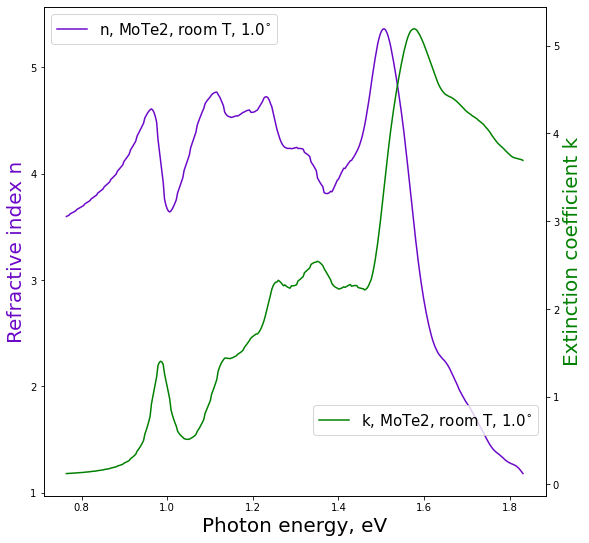

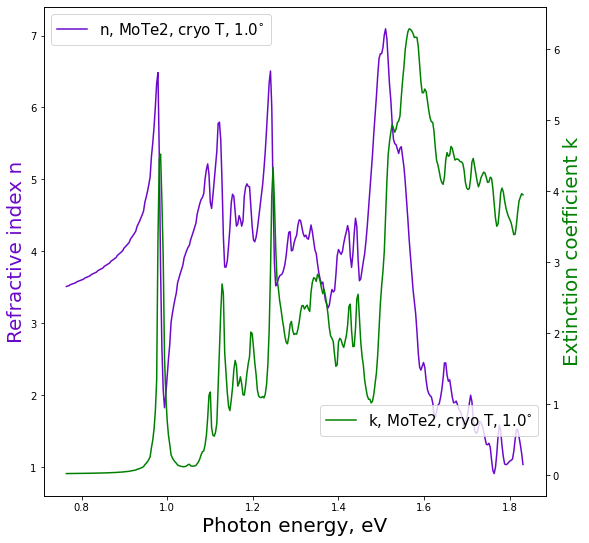

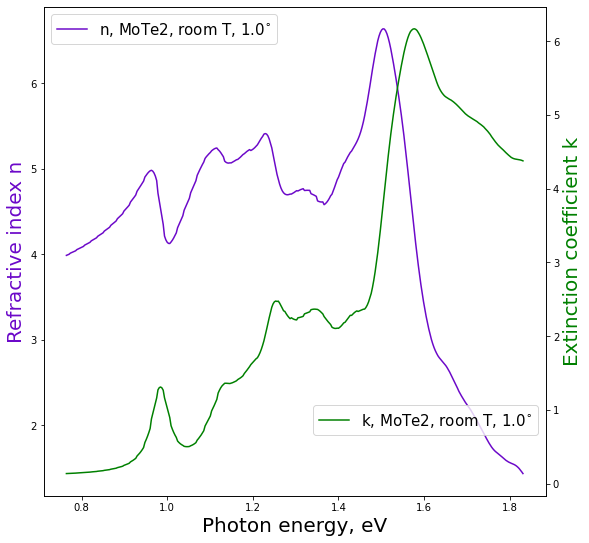

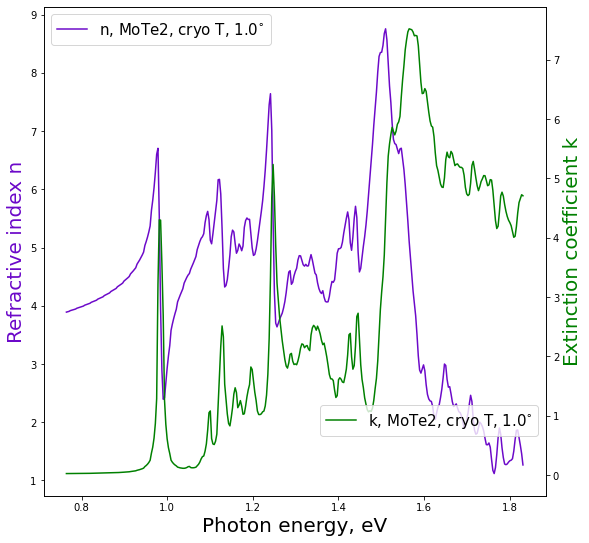

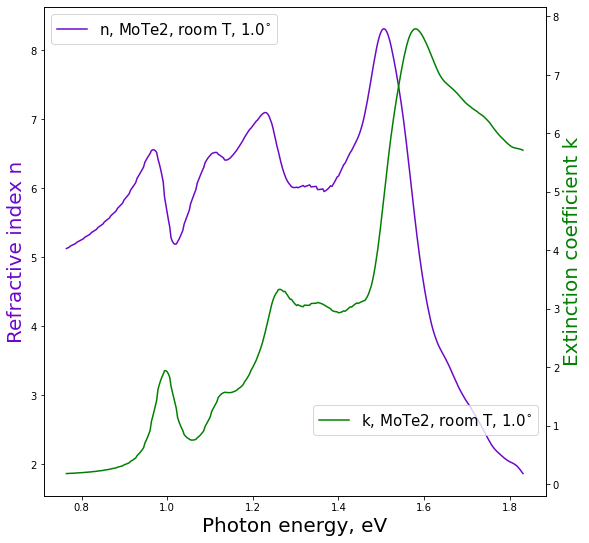

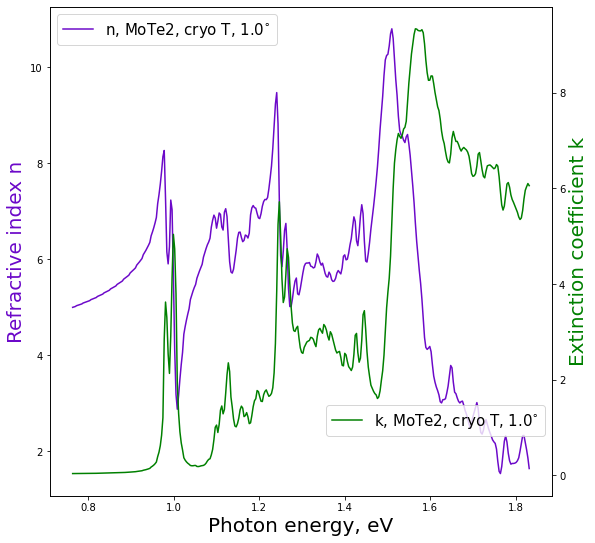

In [5]:
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import mdirac as md

##### monolayer parameters
m = 0.36
a = 3.551 # Wu (2015)
a0 = 0.52917 # [A] hydrogen 
# quasiparticle band gap -> roughly energy of continuum levels in excitons, when exciton energy is aligned properly
# 1s exciton should give 1.91 eV with 0.46 eV binding energy
Eg = 1.1+0.177
#Eg = 1.585
Ry = 13.60565 # [eV] hydrogen
eps = 4.5 # hbn encapsulated
r0 = 33.875/2.5 # [A] wu (2015)

Ry = Ry/Eg
t = np.sqrt(0.5*Ry*(1/m))*a0/a # in units of Eg
teff = 2*np.pi*t # 2pi from 2pi/a in monolayer hamiltonian
r0eff = 2*np.pi*r0/a
epseff = eps/Ry*a/a0/2


sx=np.array([[0,1],[1,0]])
sy=np.array([[0,-1j],[1j,0]])
sz=np.array([[1,0], [0,-1]]) 

def MonoHamiltonian(kx,ky,t):
    return t*sx*kx+t*sy*ky+0.5*sz

ens = [np.linalg.eigvalsh(MonoHamiltonian(kx,0,3)) for kx in np.arange(-0.5,0.5,0.01)]
fig, ax = plt.subplots(figsize=(9,9))
for i in np.arange(2):
    plt.plot(np.arange(-0.5,0.5,0.01), np.array(ens)[:,i])
plt.show()

##### grid parameters
##### 61x61 grid total if 0.005, 0.3
kstep0 = 0.005
N = int(0.3/kstep0)

def mkdir_p(mypath):
    from errno import EEXIST
    try:
        os.makedirs(mypath)
    except OSError as exc:
        if exc.errno == EEXIST and os.path.isdir(mypath):
            pass
        else: raise

path = 'out/tMoTe2corr/'+'kstep'+str(kstep0)
mkdir_p(path)
    
print('N = ', N, 'Np = ', (N+1)**2)

inds_N = np.arange(-N//2,N//2+1)
G1 = kstep0*np.array([-0.5*np.sqrt(3),0.5])
G2 = kstep0*np.array([0.5*np.sqrt(3),0.5])
listmesh = [i*G1+j*G2 for i in inds_N for j in inds_N]
mesh = np.array(listmesh)
mesh.shape

ind_v = 0
ind_c = 1

Np = mesh.shape[0]
enval = np.zeros(Np)
encond = np.zeros(Np)
Uv = np.zeros((Np,2),dtype=np.complex128)
Uc = np.zeros((Np,2),dtype=np.complex128)
dEcv = np.zeros(Np)

for i in np.arange(Np):
    ham = MonoHamiltonian(mesh[i,0],mesh[i,1],teff)
    E,U = np.linalg.eigh(ham)
    enval[i] = E[ind_v]
    encond[i] = E[ind_c]
    Uv[i] = U[:,ind_v]
    Uc[i] = U[:,ind_c]
    dEcv[i] = encond[i]-enval[i]
    
"""
W = np.zeros((Np,Np),dtype=np.complex128)
for i in np.arange(Np):
    for j in np.arange(Np):
        if i==j:
            W[i,j] = 4.254/epseff*kstep0
        else:
            kij = mesh[i]-mesh[j]
            absk = np.linalg.norm(kij)
            cc = np.vdot(Uc[i],Uc[j])
            vv = np.vdot(Uv[j],Uv[i])
            W[i,j] = np.sqrt(3)/(2*epseff)*kstep0**2*1/absk*1/(1+absk*r0eff)*cc*vv
"""
Hx = np.diag(dEcv)-W
Ex, Ux = np.linalg.eigh(Hx)
print('binding energies in monolayer: ', Eg*(1-Ex[:5]))
deg = 1 # only A exciton series, one polarization -> one valley
kcell = kstep0**2*0.5*np.sqrt(3)
factorsigma=deg*kcell*2*Ry*(a0/a)**2*(1/m)*1.j


def cov_matrix_elements(operator,Uv,Uc):
    return np.einsum('ki,ij,kj->k',Uc.conj(),operator,Uv)

def exciton_elements(Ux,cov):
    return np.einsum('nk,k->n',np.transpose(Ux),cov)

def get_sigma_xx(factor,omega,dE,rx):
    sigma=np.zeros(omega.size,dtype=np.complex128)
    for i in range(dE.shape[0]):
        s=abs(rx[i])**2
        sigma += (s/dE[i])/(omega-dE[i])+(s/dE[i])/(omega+dE[i])
    return factor*sigma

def get_sigma_xy(factor,omega,dE,rx, ry):
    sigma=np.zeros(omega.size,dtype=np.complex128)
    for i in range(dE.shape[0]):
        s=rx[i]*np.conj(ry[i])
        sigma += (s/dE[i])/(omega-dE[i])+(s/dE[i])/(omega+dE[i])
    return factor*sigma

csxv = np.zeros((Np),dtype=np.complex128)
csxv = cov_matrix_elements(sx,Uv,Uc)
xsx0 = np.zeros((Np),dtype=np.complex128)
for i in np.arange(Np):
    xsx0[i]=np.vdot(Ux[:,i],csxv)

csyv = np.zeros((Np),dtype=np.complex128)
csyv = cov_matrix_elements(sy,Uv,Uc)
xsy0 = np.zeros((Np),dtype=np.complex128)
for i in np.arange(Np):
    xsy0[i]=np.vdot(Ux[:,i],csyv)

eta_room=0.025/Eg
eta_cool=0.005/Eg
omega=np.linspace(1.e-5,2.,1000)

sigma0x_room_mono = get_sigma_xx(factorsigma,omega+1.j*eta_room,dEcv,csxv)
sigma0x_cool_mono = get_sigma_xx(factorsigma,omega+1.j*eta_cool,dEcv,csxv)
sigma0y_room_mono = get_sigma_xy(factorsigma,omega+1.j*eta_room,dEcv,csxv,csyv)
sigma0y_cool_mono = get_sigma_xy(factorsigma,omega+1.j*eta_cool,dEcv,csxv,csyv)

sigmaxx_room_mono = get_sigma_xx(factorsigma,omega+1.j*eta_room,Ex,xsx0)
sigmaxx_cool_mono = get_sigma_xx(factorsigma,omega+1.j*eta_cool,Ex,xsx0)
sigmaxy_room_mono = get_sigma_xy(factorsigma,omega+1.j*eta_room,Ex,xsx0,xsy0)
sigmaxy_cool_mono = get_sigma_xy(factorsigma,omega+1.j*eta_cool,Ex,xsx0,xsy0)

sigma_rcp0_room_mono = sigma0x_room_mono+1.j*sigma0y_room_mono
sigma_rcp_room_mono = sigmaxx_room_mono+1.j*sigmaxy_room_mono
sigma_lcp0_room_mono = sigma0x_room_mono-1.j*sigma0y_room_mono
sigma_lcp_room_mono = sigmaxx_room_mono-1.j*sigmaxy_room_mono

sigma_rcp0_cool_mono = sigma0x_cool_mono+1.j*sigma0y_cool_mono
sigma_rcp_cool_mono = sigmaxx_cool_mono+1.j*sigmaxy_cool_mono
sigma_lcp0_cool_mono = sigma0x_cool_mono-1.j*sigma0y_cool_mono
sigma_lcp_cool_mono = sigmaxx_cool_mono-1.j*sigmaxy_cool_mono

fig, ax = plt.subplots(figsize=(9,9))
left_cut = 350
right_cut = 600
ax.plot(Eg*omega[left_cut:right_cut],
        sigma_lcp_room_mono[left_cut:right_cut],
        c='b',label='mono MoTe2 room T')
ax.plot(Eg*omega[left_cut:right_cut],
        sigma_lcp0_room_mono[left_cut:right_cut],
        c='y',label='mono MoTe2 room T no exc')
ax.set_xlabel(r'$\omega$, eV',fontsize=15)
ax.set_ylabel(r'Re $\sigma_{-}$/$\sigma_0$',fontsize=15)
ax.legend(loc='upper right', fontsize=15)
fig.tight_layout()
plt.savefig(path+'/sigma_wox.png',dpi=180)
plt.close()

fig, ax = plt.subplots(figsize=(9,9))
left_cut = 350
right_cut = 600
ax.plot(Eg*omega[left_cut:right_cut],
        sigmaxx_cool_mono[left_cut:right_cut],
        c='b',label='mono MoTe2 cool T')
ax.plot(Eg*omega[left_cut:right_cut],
        sigma0x_cool_mono[left_cut:right_cut],
        c='y',label='mono MoTe2 cool T no exc')
ax.set_xlabel(r'$\omega$, eV',fontsize=15)
ax.set_ylabel(r'Re $\sigma_{xx}$/$\sigma_0$',fontsize=15)
ax.legend(loc='upper right', fontsize=15)
fig.tight_layout()
plt.savefig(path+'/sigma_wox_cool.png',dpi=180)
plt.close()

### addition of B exciton
### 460 meV spin splitting -> 1) qp bandgap is enlarged 2) solutions are shifted + delta_soc
### parameters are refreshed (new opt bandgap)

delta_soc=0.25
EgB = Eg+delta_soc

eps = 4.5 # sio2 substrate
t = np.sqrt(0.5*Ry*(1/m))*a0/a # in units of Eg
teff = 2*np.pi*t
Ry = 13.60565/EgB
epseff = eps/Ry*a/a0/2

enval = np.zeros(Np)
encond = np.zeros(Np)
Uv = np.zeros((Np,2),dtype=np.complex128)
Uc = np.zeros((Np,2),dtype=np.complex128)
dEcv = np.zeros(Np)

for i in np.arange(Np):
    ham = MonoHamiltonian(mesh[i,0],mesh[i,1],teff)
    E,U = np.linalg.eigh(ham)
    enval[i] = E[ind_v]
    encond[i] = E[ind_c]
    Uv[i] = U[:,ind_v]
    Uc[i] = U[:,ind_c]
    dEcv[i] = encond[i]-enval[i]
    
Hx = np.diag(dEcv)-W
Ex, Ux = np.linalg.eigh(Hx)

print('binding energies in monolayer MoTe2 B exciton: ', EgB*(1-Ex[:5]))

deg = 1 # only B exciton series, one polarization -> one valley
kcell = kstep0**2*0.5*np.sqrt(3)
factorsigma=deg*kcell*2*Ry*(a0/a)**2*(1/m)*1.j

csxv = np.zeros((Np),dtype=np.complex128)
csxv = cov_matrix_elements(sx,Uv,Uc)
xsx0 = np.zeros((Np),dtype=np.complex128)
for i in np.arange(Np):
    xsx0[i]=np.vdot(Ux[:,i],csxv)

csyv = np.zeros((Np),dtype=np.complex128)
csyv = cov_matrix_elements(sy,Uv,Uc)
xsy0 = np.zeros((Np),dtype=np.complex128)
for i in np.arange(Np):
    xsy0[i]=np.vdot(Ux[:,i],csyv)
    
sigma0x_room_mono_B = get_sigma_xx(factorsigma,omega+1.j*eta_room,dEcv,csxv)
sigma0x_cool_mono_B = get_sigma_xx(factorsigma,omega+1.j*eta_cool,dEcv,csxv)
sigma0y_room_mono_B = get_sigma_xy(factorsigma,omega+1.j*eta_room,dEcv,csxv,csyv)
sigma0y_cool_mono_B = get_sigma_xy(factorsigma,omega+1.j*eta_cool,dEcv,csxv,csyv)

sigmaxx_room_mono_B = get_sigma_xx(factorsigma,omega+1.j*eta_room,Ex,xsx0)
sigmaxx_cool_mono_B = get_sigma_xx(factorsigma,omega+1.j*eta_cool,Ex,xsx0)
sigmaxy_room_mono_B = get_sigma_xy(factorsigma,omega+1.j*eta_room,Ex,xsx0,xsy0)
sigmaxy_cool_mono_B = get_sigma_xy(factorsigma,omega+1.j*eta_cool,Ex,xsx0,xsy0)

sigma_rcp0_room_mono_B = sigma0x_room_mono_B+1.j*sigma0y_room_mono_B
sigma_rcp_room_mono_B = sigmaxx_room_mono_B+1.j*sigmaxy_room_mono_B
sigma_lcp0_room_mono_B = sigma0x_room_mono_B-1.j*sigma0y_room_mono_B
sigma_lcp_room_mono_B = sigmaxx_room_mono_B-1.j*sigmaxy_room_mono_B

sigma_rcp0_cool_mono_B = sigma0x_cool_mono_B+1.j*sigma0y_cool_mono_B
sigma_rcp_cool_mono_B = sigmaxx_cool_mono_B+1.j*sigmaxy_cool_mono_B
sigma_lcp0_cool_mono_B = sigma0x_cool_mono_B-1.j*sigma0y_cool_mono_B
sigma_lcp_cool_mono_B = sigmaxx_cool_mono_B-1.j*sigmaxy_cool_mono_B

### build common grid 
### energies will finally be in EgB units

sigma0x_room_mono_A = np.zeros((omega.shape[0]),dtype=np.complex128)
sigma0x_cool_mono_A = np.zeros((omega.shape[0]),dtype=np.complex128)
sigma0y_room_mono_A = np.zeros((omega.shape[0]),dtype=np.complex128)
sigma0y_cool_mono_A = np.zeros((omega.shape[0]),dtype=np.complex128)

sigmaxx_room_mono_A = np.zeros((omega.shape[0]),dtype=np.complex128)
sigmaxx_cool_mono_A = np.zeros((omega.shape[0]),dtype=np.complex128)
sigmaxy_room_mono_A = np.zeros((omega.shape[0]),dtype=np.complex128)
sigmaxy_cool_mono_A = np.zeros((omega.shape[0]),dtype=np.complex128)

sigma_rcp0_room_mono_A = np.zeros((omega.shape[0]),dtype=np.complex128)
sigma_rcp_room_mono_A = np.zeros((omega.shape[0]),dtype=np.complex128)
sigma_lcp0_room_mono_A = np.zeros((omega.shape[0]),dtype=np.complex128)
sigma_lcp_room_mono_A = np.zeros((omega.shape[0]),dtype=np.complex128)

sigma_rcp0_cool_mono_A = np.zeros((omega.shape[0]),dtype=np.complex128)
sigma_rcp_cool_mono_A = np.zeros((omega.shape[0]),dtype=np.complex128)
sigma_lcp0_cool_mono_A = np.zeros((omega.shape[0]),dtype=np.complex128)
sigma_lcp_cool_mono_A = np.zeros((omega.shape[0]),dtype=np.complex128)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

ens_A = Eg*omega
for i in range(omega.shape[0]):
    En = EgB*omega[i]
    idx = find_nearest(ens_A, En)
    sigma0x_room_mono_A[i] = sigma0x_room_mono[idx]
    sigma0x_cool_mono_A[i] = sigma0x_cool_mono[idx]
    sigma0y_room_mono_A[i] = sigma0y_room_mono[idx]
    sigma0y_cool_mono_A[i] = sigma0y_cool_mono[idx]

    sigmaxx_room_mono_A[i] = sigmaxx_room_mono[idx]
    sigmaxx_cool_mono_A[i] = sigmaxx_cool_mono[idx]
    sigmaxy_room_mono_A[i] = sigmaxy_room_mono[idx]
    sigmaxy_cool_mono_A[i] = sigmaxy_cool_mono[idx]

    sigma_rcp0_room_mono_A[i] = sigma_rcp0_room_mono[idx]
    sigma_rcp_room_mono_A[i] = sigma_rcp_room_mono[idx]
    sigma_lcp0_room_mono_A[i] = sigma_lcp0_room_mono[idx]
    sigma_lcp_room_mono_A[i] = sigma_lcp_room_mono[idx]

    sigma_rcp0_cool_mono_A[i] = sigma_rcp0_cool_mono[idx]
    sigma_rcp_cool_mono_A[i] = sigma_rcp_cool_mono[idx]
    sigma_lcp0_cool_mono_A[i] = sigma_lcp0_cool_mono[idx]
    sigma_lcp_cool_mono_A[i] = sigma_lcp_cool_mono[idx]
    
fig, ax = plt.subplots(figsize=(9,9))
left_cut = 250
right_cut = 600
ax.plot(EgB*omega[left_cut:right_cut],
        sigma_lcp_room_mono_B[left_cut:right_cut]+sigma_lcp_room_mono_A[left_cut:right_cut],
        c='b',label='mono MoTe2 left pol room T')
ax.set_xlabel(r'$\omega$, eV',fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_ylabel(r'Re $\sigma_{-}$/$\sigma_0$',fontsize=30)
ax.legend(loc='upper right', fontsize=20)
fig.tight_layout()
plt.savefig(path+'/full_mono_room',dpi=180)
plt.close()

fig, ax = plt.subplots(figsize=(9,9))
left_cut = 250
right_cut = 600
ax.plot(EgB*omega[left_cut:right_cut],
        sigma_lcp_cool_mono_B[left_cut:right_cut]+sigma_lcp_cool_mono_A[left_cut:right_cut],
        c='b',label='mono MoTe2 left pol cryo T')
ax.set_xlabel(r'$\omega$, eV',fontsize=15)
ax.set_ylabel(r'Re $\sigma_{-}$/$\sigma_0$',fontsize=15)
ax.legend(loc='upper right', fontsize=15)
fig.tight_layout()
plt.savefig(path+'/full_mono_cryo.png',dpi=180)
plt.close()

Ry = 13.60565/EgB
d = 6.15
beta = Ry*2*a0/d 
eps = 1+4*np.pi*1.j*beta*(sigma_lcp_room_mono_A+sigma_lcp_room_mono_B)/omega
refr = np.sqrt(eps)
fig, ax = plt.subplots(figsize=(9,9))
ax2=ax.twinx()
left_cut = 250
right_cut = 600
ax.plot(EgB*omega[left_cut:right_cut],refr.real[left_cut:right_cut],
        label='n, MoTe2, room T',c='#6C09C9')
ax2.plot(EgB*omega[left_cut:right_cut],refr.imag[left_cut:right_cut],
         label='k, MoTe2, room T',c='g')
ax.set_xlabel('Photon energy, eV',fontsize=20)
ax.legend(loc='upper left',fontsize=15)
ax2.legend(loc='upper right', fontsize=15)
ax.set_ylabel('Refractive index n',c='#6C09C9',fontsize=20)
ax2.set_ylabel('Extinction coefficient k',c='g',fontsize=20)
optconstspath = path + '/optconsts_room'+str(left_cut)+'_'+str(right_cut)+'.png'
plt.savefig(optconstspath,dpi=180)
tofile = np.column_stack([EgB*omega[left_cut:right_cut], 
                           refr.real[left_cut:right_cut],refr.imag[left_cut:right_cut]])
np.savetxt(path+'/optconsts'+'.txt',tofile)

tofile = np.column_stack([EgB*omega[left_cut:right_cut], 
                           sigma_lcp_room_mono_B[left_cut:right_cut].real+sigma_lcp_room_mono_A[left_cut:right_cut].real,
                          sigma_lcp_room_mono_B[left_cut:right_cut].imag+sigma_lcp_room_mono_A[left_cut:right_cut].imag])
np.savetxt(path+'/mote2'+'.txt',tofile)

tofile = np.column_stack([EgB*omega[left_cut:right_cut], 
                           sigma_lcp_cool_mono_B[left_cut:right_cut].real+sigma_lcp_cool_mono_A[left_cut:right_cut].real,
                          sigma_lcp_cool_mono_B[left_cut:right_cut].imag+sigma_lcp_cool_mono_A[left_cut:right_cut].imag])
np.savetxt(path+'/mote2cool'+'.txt',tofile)


Ry = 13.60565/EgB
d = 6.15
beta = Ry*2*a0/d 
eps = 1+4*np.pi*1.j*beta*(sigma_lcp_cool_mono_A+sigma_lcp_cool_mono_B)/omega
refr = np.sqrt(eps)
fig, ax = plt.subplots(figsize=(9,9))
ax2=ax.twinx()
left_cut = 250
right_cut = 600
ax.plot(EgB*omega[left_cut:right_cut],refr.real[left_cut:right_cut],
        label='n, MoTe2, cryo T',c='#6C09C9')
ax2.plot(EgB*omega[left_cut:right_cut],refr.imag[left_cut:right_cut],
         label='k, MoTe2, cryo T',c='g')
ax.set_xlabel('Photon energy, eV',fontsize=20)
ax.legend(loc='upper left', fontsize=15)
ax2.legend(loc='upper right', fontsize=15)
ax.set_ylabel('Refractive index n',c='#6C09C9',fontsize=20)
ax2.set_ylabel('Extinction coefficient k',c='g',fontsize=20)
optconstspath = path + '/optconsts'+str(left_cut)+'_'+str(right_cut)+'.png'
plt.savefig(optconstspath,dpi=180)



def Hamiltonian(kx,ky,t,k0):
    return np.block([[t*sx*(kx+0.5*k0)+sy*ky+0.5*sz, np.zeros((2,2))],
                     [np.zeros((2,2)), t*sx*(kx-0.5*k0)+sy*ky+0.5*sz]])

def keys(dim,i,j):
    """
    input: 4*(dim+1)**2 bands, i,j -> shifts of indices corresponding to scattering
    """
    if (dim+1)**2-abs(i*(dim+1)+j)>=0:
        ones = np.ones((dim+1)**2-abs(i*(dim+1)+j))
        sign = int(i*j<0)
        if j==1:
            for ii in range(ones.shape[0]):
                if (ii+1-sign)%(dim+1)==0:
                    ones[ii]=0
        if j==-1:
            for ii in range(ones.shape[0]):
                if (ii+1-sign)%(dim+1)==0:
                    ones[ii]=0
        return np.diag(ones,-(dim+1)*i-j)
    else:
        return 1
    

for angle in np.arange(1.0,0.6,-0.5):
    
    path = 'out/tMoTe2corr/si26_alltrans/'+'kstep'+str(kstep0)+'angle'+str(angle)
    mkdir_p(path)
    
    path_temp = path+'/temp'
    mkdir_p(path_temp)
    
    path_txt_room = 'out/tMoTe2corr/resigma26_room'
    mkdir_p(path_txt_room)
    
    path_txt_cool = 'out/tMoTe2corr/resigma26_cool'
    mkdir_p(path_txt_cool)
    
    m = 0.36
    a = 3.551 # Wu (2015)
    a0 = 0.52917 # [A] hydrogen 
    r0 = 20/4.5 # [A] wu (2015)
    # quasiparticle band gap -> roughly energy of continuum levels in excitons, when exciton energy is aligned properly
    # 1s exciton should give 1.91 eV with 0.46 eV binding energy
    Eg = 1.1+0.177
    t = np.sqrt(0.5*Ry*(1/m))*a0/a # in units of Eg
    teff = 2*np.pi*t # 2pi from 2pi/a in monolayer hamiltonian
    #Eg = 1.585
    Ry = 13.60565 # [eV] hydrogen
    eps = 4.5 # sio2 substrate

    Ry = Ry/Eg
    r0eff = 2*np.pi*r0/a
    epseff = eps/Ry*a/a0/2
    
    theta = angle*np.pi/180
    k0 = 4/3*np.sin(0.5*theta)
    
    levels=2
    edge_v = levels-1
    edge_c = levels    
    
    sigma0x_room_twist_A = np.zeros((omega.shape[0]),dtype=np.complex128)
    sigma0x_cool_twist_A = np.zeros((omega.shape[0]),dtype=np.complex128)
    sigma0y_room_twist_A = np.zeros((omega.shape[0]),dtype=np.complex128)
    sigma0y_cool_twist_A = np.zeros((omega.shape[0]),dtype=np.complex128)

    sigmaxx_room_twist_A = np.zeros((omega.shape[0]),dtype=np.complex128)
    sigmaxx_cool_twist_A = np.zeros((omega.shape[0]),dtype=np.complex128)
    sigmaxy_room_twist_A = np.zeros((omega.shape[0]),dtype=np.complex128)
    sigmaxy_cool_twist_A = np.zeros((omega.shape[0]),dtype=np.complex128)

    sigma_rcp0_room_twist_A = np.zeros((omega.shape[0]),dtype=np.complex128)
    sigma_rcp_room_twist_A = np.zeros((omega.shape[0]),dtype=np.complex128)
    sigma_lcp0_room_twist_A = np.zeros((omega.shape[0]),dtype=np.complex128)
    sigma_lcp_room_twist_A = np.zeros((omega.shape[0]),dtype=np.complex128)

    sigma_rcp0_cool_twist_A = np.zeros((omega.shape[0]),dtype=np.complex128)
    sigma_rcp_cool_twist_A = np.zeros((omega.shape[0]),dtype=np.complex128)
    sigma_lcp0_cool_twist_A = np.zeros((omega.shape[0]),dtype=np.complex128)
    sigma_lcp_cool_twist_A = np.zeros((omega.shape[0]),dtype=np.complex128)
    
    sigma0x_room_twist_B = np.zeros((omega.shape[0]),dtype=np.complex128)
    sigma0x_cool_twist_B = np.zeros((omega.shape[0]),dtype=np.complex128)
    sigma0y_room_twist_B = np.zeros((omega.shape[0]),dtype=np.complex128)
    sigma0y_cool_twist_B = np.zeros((omega.shape[0]),dtype=np.complex128)

    sigmaxx_room_twist_B = np.zeros((omega.shape[0]),dtype=np.complex128)
    sigmaxx_cool_twist_B = np.zeros((omega.shape[0]),dtype=np.complex128)
    sigmaxy_room_twist_B = np.zeros((omega.shape[0]),dtype=np.complex128)
    sigmaxy_cool_twist_B = np.zeros((omega.shape[0]),dtype=np.complex128)

    sigma_rcp0_room_twist_B = np.zeros((omega.shape[0]),dtype=np.complex128)
    sigma_rcp_room_twist_B = np.zeros((omega.shape[0]),dtype=np.complex128)
    sigma_lcp0_room_twist_B = np.zeros((omega.shape[0]),dtype=np.complex128)
    sigma_lcp_room_twist_B = np.zeros((omega.shape[0]),dtype=np.complex128)

    sigma_rcp0_cool_twist_B = np.zeros((omega.shape[0]),dtype=np.complex128)
    sigma_rcp_cool_twist_B = np.zeros((omega.shape[0]),dtype=np.complex128)
    sigma_lcp0_cool_twist_B = np.zeros((omega.shape[0]),dtype=np.complex128)
    sigma_lcp_cool_twist_B = np.zeros((omega.shape[0]),dtype=np.complex128)
    
    for ind_v in np.arange(edge_v,edge_v-levels,-1):
        for ind_c in np.arange(edge_c,edge_c+levels,1):

            Uv = np.zeros((Np,4),dtype=np.complex128)
            Uc = np.zeros((Np,4),dtype=np.complex128)

            for i in np.arange(Np):
                ham = Hamiltonian(mesh[i,0],mesh[i,1],teff,k0)
                E,U = np.linalg.eigh(ham)
                enval[i] = E[ind_v]
                encond[i] = E[ind_c]
                Uv[i] = U[:,ind_v]
                Uc[i] = U[:,ind_c]
                dEcv[i] = encond[i]-enval[i]
            
            Hx = np.diag(dEcv)-W

            MP = np.zeros((Np,Np),dtype=np.complex128)
            nm = int(k0*np.sqrt(3)/kstep0)
            V=0.026/Eg # 18/36 meV Moire potential magnitude

            MP = (keys(N,nm,0)+keys(N,0,nm)+keys(N,-nm,-nm)+keys(N,-nm,0)+keys(N,0,-nm)+keys(N,nm,nm))*(-V)

            HxM = Hx+MP
            Ex,Ux = np.linalg.eigh(HxM)

            print('binding energies in twist MoTe2 '+str(angle)+ r'$^{\circ}$', Eg*(1-Ex[:5]))
            deg = 1
            kcell = kstep0**2*0.5*np.sqrt(3)
            factorsigma=deg*kcell*2*Ry*(a0/a)**2*(1/m)*1.j

            Sx = np.kron(np.identity(2),sx)
            Sy = np.kron(np.identity(2),sy)

            csxv = np.zeros((Np),dtype=np.complex128)
            csxv = cov_matrix_elements(Sx,Uv,Uc)
            xsx0 = np.zeros((Np),dtype=np.complex128)
            for i in np.arange(Np):
                xsx0[i]=np.vdot(Ux[:,i],csxv)

            csyv = np.zeros((Np),dtype=np.complex128)
            csyv = cov_matrix_elements(Sy,Uv,Uc)
            xsy0 = np.zeros((Np),dtype=np.complex128)
            for i in np.arange(Np):
                xsy0[i]=np.vdot(Ux[:,i],csyv)

            sigma0x_room_twist = get_sigma_xx(factorsigma,omega+1.j*eta_room,dEcv,csxv)
            sigma0x_cool_twist = get_sigma_xx(factorsigma,omega+1.j*eta_cool,dEcv,csxv)
            sigma0y_room_twist = get_sigma_xy(factorsigma,omega+1.j*eta_room,dEcv,csxv,csyv)
            sigma0y_cool_twist = get_sigma_xy(factorsigma,omega+1.j*eta_cool,dEcv,csxv,csyv)

            sigmaxx_room_twist = get_sigma_xx(factorsigma,omega+1.j*eta_room,Ex,xsx0)
            sigmaxx_cool_twist = get_sigma_xx(factorsigma,omega+1.j*eta_cool,Ex,xsx0)
            sigmaxy_room_twist = get_sigma_xy(factorsigma,omega+1.j*eta_room,Ex,xsx0,xsy0)
            sigmaxy_cool_twist = get_sigma_xy(factorsigma,omega+1.j*eta_cool,Ex,xsx0,xsy0)

            sigma_rcp0_room_twist = sigma0x_room_twist+1.j*sigma0y_room_twist
            sigma_rcp_room_twist = sigmaxx_room_twist+1.j*sigmaxy_room_twist
            sigma_lcp0_room_twist = sigma0x_room_twist-1.j*sigma0y_room_twist
            sigma_lcp_room_twist = sigmaxx_room_twist-1.j*sigmaxy_room_twist

            sigma_rcp0_cool_twist = sigma0x_cool_twist+1.j*sigma0y_cool_twist
            sigma_rcp_cool_twist = sigmaxx_cool_twist+1.j*sigmaxy_cool_twist
            sigma_lcp0_cool_twist = sigma0x_cool_twist-1.j*sigma0y_cool_twist
            sigma_lcp_cool_twist = sigmaxx_cool_twist-1.j*sigmaxy_cool_twist

            fig, ax = plt.subplots(figsize=(9,9))
            left_cut = 350
            right_cut = 600
            ax.plot(Eg*omega[left_cut:right_cut],
                    sigma_lcp_room_twist[left_cut:right_cut],
                    c='b',label='twist MoTe2 left pol room T '+str(angle)+r'$^{\circ}$')
            ax.plot(Eg*omega[left_cut:right_cut],
                    sigma_lcp0_room_twist[left_cut:right_cut],
                    c='y',label='twist MoTe2 left pol room T no exc '+str(angle)+r'$^{\circ}$')
            ax.set_xlabel(r'$\omega$, eV',fontsize=15)
            ax.set_ylabel(r'Re $\sigma_{-}$/$\sigma_0$',fontsize=15)
            ax.legend(loc='upper right', fontsize=15)
            fig.tight_layout()
            plt.savefig(path_temp+'/twist_wox_'+'vc'+str(ind_v)+str(ind_c)+'.png',dpi=180)
            plt.close()


            fig, ax = plt.subplots(figsize=(9,9))
            left_cut = 350
            right_cut = 600
            ax.plot(Eg*omega[left_cut:right_cut],
                    sigmaxx_cool_twist[left_cut:right_cut],
                    c='b',label='twist MoTe2 left pol cool T '+str(angle)+r'$^{\circ}$')
            ax.plot(Eg*omega[left_cut:right_cut],
                    sigma0x_cool_twist[left_cut:right_cut],
                    c='y',label='twist MoTe2 left pol cool T no exc '+str(angle)+r'$^{\circ}$')
            ax.set_xlabel(r'$\omega$, eV',fontsize=15)
            ax.set_ylabel(r'Re $\sigma_{-}$/$\sigma_0$',fontsize=15)
            ax.legend(loc='upper right', fontsize=15)
            fig.tight_layout()
            plt.savefig(path_temp+'/twist_wox_cool'+str(ind_v)+str(ind_c)+'.png',dpi=180)
            plt.close()

            fig, ax = plt.subplots(figsize=(9,9))
            left_cut = 350
            right_cut = 600
            ax.plot(Eg*omega[left_cut:right_cut],
                    2*sigmaxx_cool_twist[left_cut:right_cut],
                    c='b',label='twist MoTe2 cool T A exciton '+str(angle)+r'$^{\circ}$')
            ax.plot(Eg*omega[left_cut:right_cut],
                    2*sigmaxx_cool_mono[left_cut:right_cut],
                    c='y',label='mono MoTe2 cool T A exciton')
            ax.set_xlabel(r'$\omega$, eV',fontsize=15)
            ax.set_ylabel(r'Re $\sigma_{xx}$/$\sigma_0$',fontsize=15)
            ax.legend(loc='upper right', fontsize=15)
            fig.tight_layout()
            plt.savefig(path_temp+'/twistmonoAexc_cool'+str(ind_v)+str(ind_c)+'.png',dpi=180)
            plt.close()

            fig, ax = plt.subplots(figsize=(9,9))
            left_cut = 350
            right_cut = 600
            ax.plot(Eg*omega[left_cut:right_cut],
                    2*sigmaxx_room_twist[left_cut:right_cut],
                    c='b',label='twist MoTe2 room T '+str(angle)+r'$^{\circ}$')
            ax.plot(Eg*omega[left_cut:right_cut],
                    2*sigmaxx_room_mono[left_cut:right_cut],
                    c='y',label='mono MoTe2 room T')
            ax.set_xlabel(r'$\omega$, eV',fontsize=15)
            ax.set_ylabel(r'Re $\sigma_{xx}$/$\sigma_0$',fontsize=15)
            ax.legend(loc='upper right', fontsize=15)
            fig.tight_layout()
            plt.savefig(path_temp+'/twistmonoAexc_room'+str(ind_v)+str(ind_c)+'.png',dpi=180)
            plt.close()

            ### addition of B exciton
            ### 460 meV spin splitting -> 1) qp bandgap is enlarged 2) solutions are shifted + delta_soc
            ### parameters are refreshed (new opt bandgap)

            delta_soc=0.25
            EgB = Eg+delta_soc

            eps = 4.5 # sio2 substrate
            Ry = 13.60565/EgB
            t = np.sqrt(0.5*Ry*(1/m))*a0/a # in units of Eg
            teff = 2*np.pi*t
            epseff = eps/Ry*a/a0/2

            enval = np.zeros(Np)
            encond = np.zeros(Np)
            Uv = np.zeros((Np,4),dtype=np.complex128)
            Uc = np.zeros((Np,4),dtype=np.complex128)
            dEcv = np.zeros(Np)

            for i in np.arange(Np):
                ham = Hamiltonian(mesh[i,0],mesh[i,1],teff,k0)
                E,U = np.linalg.eigh(ham)
                enval[i] = E[ind_v]
                encond[i] = E[ind_c]
                Uv[i] = U[:,ind_v]
                Uc[i] = U[:,ind_c]
                dEcv[i] = encond[i]-enval[i]

            Hx = np.diag(dEcv)-W
            Ex, Ux = np.linalg.eigh(Hx)

            print('binding energies in monolayer WSe2 B exciton' + str(angle)+r'$^{\circ}$'+':' , EgB*(1-Ex[:10]))

            deg = 1 # only B exciton series, one polarization -> one valley
            kcell = kstep0**2*0.5*np.sqrt(3)
            factorsigma=deg*kcell*2*Ry*(a0/a)**2*(1/m)*1.j

            csxv = np.zeros((Np),dtype=np.complex128)
            csxv = cov_matrix_elements(Sx,Uv,Uc)
            xsx0 = np.zeros((Np),dtype=np.complex128)
            for i in np.arange(Np):
                xsx0[i]=np.vdot(Ux[:,i],csxv)

            csyv = np.zeros((Np),dtype=np.complex128)
            csyv = cov_matrix_elements(Sy,Uv,Uc)
            xsy0 = np.zeros((Np),dtype=np.complex128)
            for i in np.arange(Np):
                xsy0[i]=np.vdot(Ux[:,i],csyv)

            eta_room=0.025/Eg
            eta_cool=0.005/Eg
            omega=np.linspace(1.e-5,2.,1000)

            sigma0x_room_twist_B += get_sigma_xx(factorsigma,omega+1.j*eta_room,dEcv,csxv)
            sigma0x_cool_twist_B += get_sigma_xx(factorsigma,omega+1.j*eta_cool,dEcv,csxv)
            sigma0y_room_twist_B += get_sigma_xy(factorsigma,omega+1.j*eta_room,dEcv,csxv,csyv)
            sigma0y_cool_twist_B += get_sigma_xy(factorsigma,omega+1.j*eta_cool,dEcv,csxv,csyv)

            sigmaxx_room_twist_B += get_sigma_xx(factorsigma,omega+1.j*eta_room,Ex,xsx0)
            sigmaxx_cool_twist_B += get_sigma_xx(factorsigma,omega+1.j*eta_cool,Ex,xsx0)
            sigmaxy_room_twist_B += get_sigma_xy(factorsigma,omega+1.j*eta_room,Ex,xsx0,xsy0)
            sigmaxy_cool_twist_B += get_sigma_xy(factorsigma,omega+1.j*eta_cool,Ex,xsx0,xsy0)

            sigma_rcp0_room_twist_B += sigma0x_room_twist_B+1.j*sigma0y_room_twist_B
            sigma_rcp_room_twist_B += sigmaxx_room_twist_B+1.j*sigmaxy_room_twist_B
            sigma_lcp0_room_twist_B += sigma0x_room_twist_B-1.j*sigma0y_room_twist_B
            sigma_lcp_room_twist_B += sigmaxx_room_twist_B-1.j*sigmaxy_room_twist_B

            sigma_rcp0_cool_twist_B += sigma0x_cool_twist_B+1.j*sigma0y_cool_twist_B
            sigma_rcp_cool_twist_B += sigmaxx_cool_twist_B+1.j*sigmaxy_cool_twist_B
            sigma_lcp0_cool_twist_B += sigma0x_cool_twist_B-1.j*sigma0y_cool_twist_B
            sigma_lcp_cool_twist_B += sigmaxx_cool_twist_B-1.j*sigmaxy_cool_twist_B

            ### build common grid 
            ### energies will finally be in EgB units

            def find_nearest(array, value):
                array = np.asarray(array)
                idx = (np.abs(array - value)).argmin()
                return idx

            ens_A = Eg*omega
            for i in range(omega.shape[0]):
                En = EgB*omega[i]
                idx = find_nearest(ens_A, En)
                sigma0x_room_twist_A[i] += sigma0x_room_twist[idx]
                sigma0x_cool_twist_A[i] += sigma0x_cool_twist[idx]
                sigma0y_room_twist_A[i] += sigma0y_room_twist[idx]
                sigma0y_cool_twist_A[i] += sigma0y_cool_twist[idx]

                sigmaxx_room_twist_A[i] += sigmaxx_room_twist[idx]
                sigmaxx_cool_twist_A[i] += sigmaxx_cool_twist[idx]
                sigmaxy_room_twist_A[i] += sigmaxy_room_twist[idx]
                sigmaxy_cool_twist_A[i] += sigmaxy_cool_twist[idx]

                sigma_rcp0_room_twist_A[i] += sigma_rcp0_room_twist[idx]
                sigma_rcp_room_twist_A[i] += sigma_rcp_room_twist[idx]
                sigma_lcp0_room_twist_A[i] += sigma_lcp0_room_twist[idx]
                sigma_lcp_room_twist_A[i] += sigma_lcp_room_twist[idx]

                sigma_rcp0_cool_twist_A[i] += sigma_rcp0_cool_twist[idx]
                sigma_rcp_cool_twist_A[i] += sigma_rcp_cool_twist[idx]
                sigma_lcp0_cool_twist_A[i] += sigma_lcp0_cool_twist[idx]
                sigma_lcp_cool_twist_A[i] += sigma_lcp_cool_twist[idx]

                
            fig, ax = plt.subplots(figsize=(9,9))
            left_cut = 250
            right_cut = 600
            ax.plot(EgB*omega[left_cut:right_cut],
                    sigma_lcp_room_twist_B[left_cut:right_cut]+sigma_lcp_room_twist_A[left_cut:right_cut],
                    c='b',label='twist MoTe2 left pol room T '+str(angle)+r'$^{\circ}$')
            ax.set_xlabel(r'$\omega$, eV',fontsize=15)
            ax.set_ylabel(r'Re $\sigma_{-}$/$\sigma_0$',fontsize=15)
            ax.legend(loc='upper right', fontsize=15)
            fig.tight_layout()
            plt.savefig(path_temp+'/twist_B_room'+str(ind_v)+str(ind_c)+'.png',dpi=180)
            plt.close()

            fig, ax = plt.subplots(figsize=(9,9))
            left_cut = 250
            right_cut = 600
            ax.plot(EgB*omega[left_cut:right_cut],
                    sigma_lcp_room_twist_B[left_cut:right_cut]+sigma_lcp_room_twist_A[left_cut:right_cut],
                    c='b',label='twist MoTe2 left pol room T '+str(angle)+r'$^{\circ}$')
            ax.plot(EgB*omega[left_cut:right_cut],
                    sigma_lcp_room_mono_B[left_cut:right_cut]+sigma_lcp_room_mono_A[left_cut:right_cut],
                    c='r',label='mono MoTe2 left pol room T')
            ax.set_xlabel(r'$\omega$, eV',fontsize=15)
            ax.set_ylabel(r'Re $\sigma_{-}$/$\sigma_0$',fontsize=15)
            ax.legend(loc='upper right', fontsize=15)
            fig.tight_layout()
            plt.savefig(path_temp+'/twistmono_room'+str(ind_v)+str(ind_c)+'.png',dpi=180)
            plt.close()

            fig, ax = plt.subplots(figsize=(9,9))
            left_cut = 250
            right_cut = 600
            ax.plot(EgB*omega[left_cut:right_cut],
                    2*sigmaxx_room_twist_B[left_cut:right_cut]+sigmaxx_room_twist_A[left_cut:right_cut],
                    c='b',label='twist MoTe2 room T '+str(angle)+r'$^{\circ}$')
            ax.plot(EgB*omega[left_cut:right_cut],
                    2*sigmaxx_room_mono_B[left_cut:right_cut]+sigmaxx_room_mono_A[left_cut:right_cut],
                    c='r',label='mono MoTe2 room T')
            ax.set_xlabel(r'$\omega$, eV',fontsize=15)
            ax.set_ylabel(r'Re $\sigma_{xx}$/$\sigma_0$',fontsize=15)
            ax.legend(loc='upper right', fontsize=15)
            fig.tight_layout()
            plt.savefig(path_temp+'/twistmono_room_xx'+str(ind_v)+str(ind_c)+'.png',dpi=180)
            plt.close()

            fig, ax = plt.subplots(figsize=(9,9))
            left_cut = 250
            right_cut = 600
            ax.plot(EgB*omega[left_cut:right_cut],
                    sigma_lcp_cool_twist_B[left_cut:right_cut]+sigma_lcp_cool_twist_A[left_cut:right_cut],
                    c='b',label='twist MoTe2 left pol cool T')
            ax.plot(EgB*omega[left_cut:right_cut],
                    sigma_lcp_cool_mono_B[left_cut:right_cut]+sigma_lcp_cool_mono_A[left_cut:right_cut],
                    c='r',label='mono MoTe2 left pol cool T')
            ax.set_xlabel(r'$\omega$, eV',fontsize=15)
            ax.set_ylabel(r'Re $\sigma_{-}$/$\sigma_0$',fontsize=15)
            ax.legend(loc='upper right', fontsize=15)
            fig.tight_layout()
            plt.savefig(path_temp+'/twistmono_cool'+str(ind_v)+str(ind_c)+'.png',dpi=180)
            plt.close()

            Ry = 13.60565/EgB
            d = 2*6.15
            beta = Ry*2*a0/d 
            eps = 1+4*np.pi*1.j*beta*(sigma_lcp_room_twist_A+sigma_lcp_room_twist_B)/omega
            refr = np.sqrt(eps)
            fig, ax = plt.subplots(figsize=(9,9))
            ax2=ax.twinx()
            left_cut = 250
            right_cut = 600
            ax.plot(EgB*omega[left_cut:right_cut],refr.real[left_cut:right_cut],
                    label='n, MoTe2, room T, '+str(angle)+r'$^{\circ}$',c='#6C09C9')
            ax2.plot(EgB*omega[left_cut:right_cut],refr.imag[left_cut:right_cut],
                     label='k, MoTe2, room T, '+str(angle)+r'$^{\circ}$',c='g')
            ax.set_xlabel('Photon energy, eV',fontsize=20)
            ax.legend(loc='upper left',fontsize=15)
            ax2.legend(loc='upper right', bbox_to_anchor=(1,0.2),fontsize=15)
            ax.set_ylabel('Refractive index n',c='#6C09C9')
            ax2.set_ylabel('Extinction coefficient k',c='g')
            ax.set_ylabel('Refractive index n',c='#6C09C9',fontsize=20)
            ax2.set_ylabel('Extinction coefficient k',c='g',fontsize=20)
            optconstspath = path_temp + '/optconsts'+str(left_cut)+'_'+str(right_cut)+'.png'
            plt.savefig(optconstspath,dpi=180)
            tofile = np.column_stack([EgB*omega[left_cut:right_cut], 
                                       refr.real[left_cut:right_cut],refr.imag[left_cut:right_cut]])
            np.savetxt(path_temp+'/optconsts_room'+str(ind_v)+str(ind_c)+'.txt',tofile)

            Ry = 13.60565/EgB
            d = 2*6.49
            beta = Ry*2*a0/d
            eps = 1+4*np.pi*1.j*beta*(sigma_lcp_cool_twist_A+sigma_lcp_cool_twist_B)/omega
            refr = np.sqrt(eps)
            fig, ax = plt.subplots(figsize=(9,9))
            ax2=ax.twinx()
            left_cut = 250
            right_cut = 600
            ax.plot(EgB*omega[left_cut:right_cut],refr.real[left_cut:right_cut],
                    label='n, MoTe2, cryo T, '+str(angle)+r'$^{\circ}$',c='#6C09C9')
            ax2.plot(EgB*omega[left_cut:right_cut],refr.imag[left_cut:right_cut],
                     label='k, MoTe2, cryo T, '+str(angle)+r'$^{\circ}$',c='g')
            ax.set_xlabel('Photon energy, eV',fontsize=20)
            ax.legend(loc='upper left', fontsize=15)
            ax2.legend(loc='upper right', bbox_to_anchor=(1,0.2), fontsize=15)
            ax.set_ylabel('Refractive index n',c='#6C09C9',fontsize=20)
            ax2.set_ylabel('Extinction coefficient k',c='g',fontsize=20)
            optconstspath = path_temp + '/optconsts'+str(left_cut)+'_'+str(right_cut)+'_'+str(ind_v)+str(ind_c)+'.png'
            plt.savefig(optconstspath,dpi=180)
            tofile = np.column_stack([EgB*omega[left_cut:right_cut], 
                                       refr.real[left_cut:right_cut],refr.imag[left_cut:right_cut]])
            np.savetxt(path_temp+'/optconsts'+str(angle)+'.txt',tofile)

    fig, ax = plt.subplots(figsize=(9,9))
    left_cut = 250
    right_cut = 600
    ax.plot(EgB*omega[left_cut:right_cut],
            sigma_lcp_cool_twist_B[left_cut:right_cut]+sigma_lcp_cool_twist_A[left_cut:right_cut],
            c='b',label='twist MoTe2 left pol cool T')
    ax.plot(EgB*omega[left_cut:right_cut],
            sigma_lcp_cool_mono_B[left_cut:right_cut]+sigma_lcp_cool_mono_A[left_cut:right_cut],
            c='r',label='mono MoTe2 left pol cool T')
    ax.set_xlabel(r'$\omega$, eV',fontsize=15)
    ax.set_ylabel(r'Re $\sigma_{-}$/$\sigma_0$',fontsize=15)
    ax.legend(loc='upper right', fontsize=15)
    fig.tight_layout()
    plt.savefig(path+'/twistmono_cool.png',dpi=180)
    plt.close()
    
    fig, ax = plt.subplots(figsize=(9,9))
    left_cut = 250
    right_cut = 600
    ax.plot(EgB*omega[left_cut:right_cut],
            sigma_lcp_room_twist_B[left_cut:right_cut]+sigma_lcp_room_twist_A[left_cut:right_cut],
            c='b',label='twist MoTe2 left pol room T '+str(angle)+r'$^{\circ}$')
    ax.plot(EgB*omega[left_cut:right_cut],
            sigma_lcp_room_mono_B[left_cut:right_cut]+sigma_lcp_room_mono_A[left_cut:right_cut],
            c='r',label='mono MoTe2 left pol room T')
    ax.set_xlabel(r'$\omega$, eV',fontsize=15)
    ax.set_ylabel(r'Re $\sigma_{-}$/$\sigma_0$',fontsize=15)
    ax.legend(loc='upper right', fontsize=15)
    fig.tight_layout()
    plt.savefig(path+'/twistmono_room.png',dpi=180)
    plt.close()
    
    
    sigma0x_room_twist_full = np.column_stack([EgB*omega,
                                               sigma0x_room_twist_A.real+sigma0x_room_twist_B.real,
                                               sigma0x_room_twist_A.imag+sigma0x_room_twist_B.imag])
    np.savetxt(path+'/sigma0x_room_twist_full.txt', sigma0x_room_twist_full)
    sigma0x_cool_twist_full = np.column_stack([EgB*omega,
                                               sigma0x_cool_twist_A.real+sigma0x_cool_twist_B.real,
                                               sigma0x_cool_twist_A.imag+sigma0x_cool_twist_B.imag])
    np.savetxt(path+'/sigma0x_cool_twist_full.txt', sigma0x_cool_twist_full)
    sigma0y_room_twist_full = np.column_stack([EgB*omega,
                                               sigma0y_room_twist_A.real+sigma0y_room_twist_B.real,
                                               sigma0y_room_twist_A.imag+sigma0y_room_twist_B.imag])
    np.savetxt(path+'/sigma0y_room_twist_full.txt', sigma0y_room_twist_full)
    sigma0y_cool_twist_full = np.column_stack([EgB*omega,
                                               sigma0y_cool_twist_A.real+sigma0y_cool_twist_B.real,
                                               sigma0y_cool_twist_A.imag+sigma0y_cool_twist_B.imag])
    np.savetxt(path+'/sigma0y_cool_twist_full.txt', sigma0y_cool_twist_full)
    
    sigmaxx_room_twist_full = np.column_stack([EgB*omega,
                                               sigmaxx_room_twist_A.real+sigmaxx_room_twist_B.real,
                                               sigmaxx_room_twist_A.imag+sigmaxx_room_twist_B.imag])
    np.savetxt(path+'/sigmaxx_room_twist_full.txt', sigmaxx_room_twist_full)
    sigmaxx_cool_twist_full = np.column_stack([EgB*omega,
                                               sigmaxx_cool_twist_A.real+sigmaxx_cool_twist_B.real,
                                               sigmaxx_cool_twist_A.imag+sigmaxx_cool_twist_B.imag])
    np.savetxt(path+'/sigmaxx_cool_twist_full.txt', sigmaxx_cool_twist_full)
    sigmaxy_room_twist_full = np.column_stack([EgB*omega,
                                               sigmaxy_room_twist_A.real+sigmaxy_room_twist_B.real,
                                               sigmaxy_room_twist_A.imag+sigmaxy_room_twist_B.imag])
    np.savetxt(path+'/sigmaxy_room_twist_full.txt', sigmaxy_room_twist_full)
    sigmaxy_cool_twist_full = np.column_stack([EgB*omega,
                                               sigmaxy_cool_twist_A.real+sigmaxy_cool_twist_B.real,
                                               sigmaxy_cool_twist_A.imag+sigmaxy_cool_twist_B.imag])
    np.savetxt(path+'/sigmaxy_cool_twist_full.txt', sigmaxy_cool_twist_full)
    
    
    sigma_lcp0_room_twist_full = np.column_stack([EgB*omega,
                                               sigma_lcp0_room_twist_A.real+sigma_lcp0_room_twist_B.real,
                                               sigma_lcp0_room_twist_A.imag+sigma_lcp0_room_twist_B.imag])
    np.savetxt(path+'/sigma_lcp0_room_twist_full.txt', sigma_lcp0_room_twist_full)
    sigma_lcp0_cool_twist_full = np.column_stack([EgB*omega,
                                               sigma_lcp0_cool_twist_A.real+sigma_lcp0_cool_twist_B.real,
                                               sigma_lcp0_cool_twist_A.imag+sigma_lcp0_cool_twist_B.imag])
    np.savetxt(path+'/sigma_lcp0_cool_twist_full.txt', sigma_lcp0_cool_twist_full)
    sigma_rcp0_room_twist_full = np.column_stack([EgB*omega,
                                               sigma_rcp0_room_twist_A.real+sigma_rcp0_room_twist_B.real,
                                               sigma_rcp0_room_twist_A.imag+sigma_rcp0_room_twist_B.imag])
    np.savetxt(path+'/sigma_rcp0_room_twist_full.txt', sigma_rcp0_room_twist_full)
    sigma_rcp0_cool_twist_full = np.column_stack([EgB*omega,
                                               sigma_rcp0_cool_twist_A.real+sigma_rcp0_cool_twist_B.real,
                                               sigma_rcp0_cool_twist_A.imag+sigma_rcp0_cool_twist_B.imag])
    np.savetxt(path+'/sigma_rcp0_cool_twist_full.txt', sigma_rcp0_cool_twist_full)
    
    sigma_lcp_room_twist_full = np.column_stack([EgB*omega,
                                               sigma_lcp_room_twist_A.real+sigma_lcp_room_twist_B.real,
                                               sigma_lcp_room_twist_A.imag+sigma_lcp_room_twist_B.imag])
    np.savetxt(path+'/sigma_lcp_room_twist_full.txt', sigma_lcp_room_twist_full)
    sigma_lcp_cool_twist_full = np.column_stack([EgB*omega,
                                               sigma_lcp_cool_twist_A.real+sigma_lcp_cool_twist_B.real,
                                               sigma_lcp_cool_twist_A.imag+sigma_lcp_cool_twist_B.imag])
    np.savetxt(path+'/sigma_lcp_cool_twist_full.txt', sigma_lcp_cool_twist_full)
    sigma_rcp_room_twist_full = np.column_stack([EgB*omega,
                                               sigma_rcp_room_twist_A.real+sigma_rcp_room_twist_B.real,
                                               sigma_rcp_room_twist_A.imag+sigma_rcp_room_twist_B.imag])
    
    np.savetxt(path_txt_room+'/sigma_lcp_room_twist_full'+str(angle)+'.txt', sigma_lcp_room_twist_full)
    np.savetxt(path_txt_cool+'/sigma_lcp_room_twist_full'+str(angle)+'.txt', sigma_lcp_cool_twist_full)
    
    np.savetxt(path+'/sigma_rcp_room_twist_full.txt', sigma_rcp_room_twist_full)
    sigma_rcp_cool_twist_full = np.column_stack([EgB*omega,
                                               sigma_rcp_cool_twist_A.real+sigma_rcp_cool_twist_B.real,
                                               sigma_rcp_cool_twist_A.imag+sigma_rcp_cool_twist_B.imag])
    np.savetxt(path+'/sigma_rcp_cool_twist_full.txt', sigma_rcp_cool_twist_full)
